# 🚀 Bitcoin Forecasting & Anomaly Detection
This notebook includes:
- Tuned GRU Forecasting
- Anomaly Detection logic
- Visualizations and evaluation metrics

## 🔁 GRU Forecasting (Tuned)

✅ Hourly rows available: 17457
✅ X shape after reshape: (17407, 50, 1)
✅ y shape: (17407, 1)
X shape: (17407, 50, 1)
y shape: (17407, 1)
Epoch 1/30


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.0663e-04 - val_loss: 5.0991e-04
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8233e-05 - val_loss: 7.4130e-04
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0462e-05 - val_loss: 2.9195e-04
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7913e-05 - val_loss: 5.0201e-04
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6385e-05 - val_loss: 3.0199e-04
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6068e-05 - val_loss: 3.4141e-04
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4239e-05 - val_loss: 2.8543e-04
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4196e-05 - val_loss: 2.6036e-04
Epoch 9/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6589e-05 - val_loss: 5.6805e-04
Epoch 10/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3407e-05 - val_loss: 0.0017
Epoch 11/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8859e-05 - 

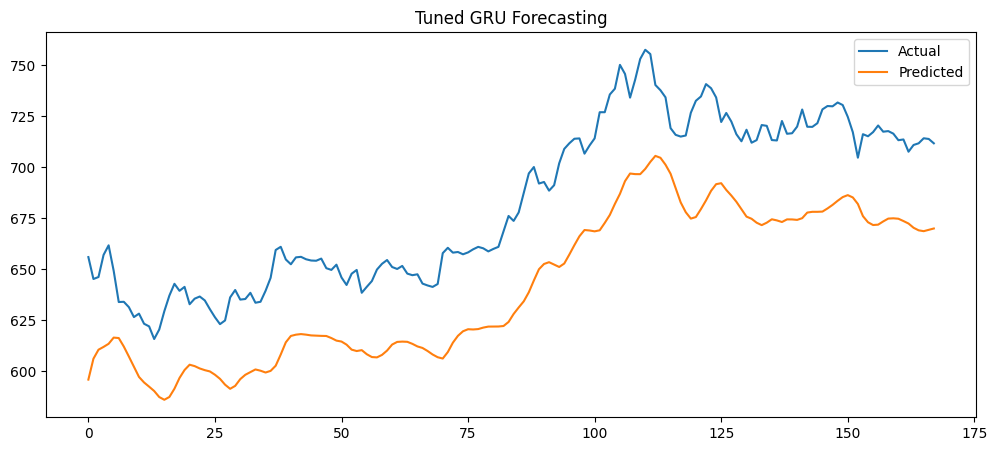

In [15]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df_raw = pd.read_csv("btcusd_1-min_data.csv")
df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")
df_raw = df_raw.dropna(subset=["datetime"])
df_raw.set_index("datetime", inplace=True)
df = df_raw[["Close"]].dropna()

# Now resample
df_hourly = df.resample("1h").mean().dropna().rename(columns={"Close": "y"})
print("✅ Hourly rows available:", len(df_hourly))

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_hourly[['y']].values)

# Step 2: Create sequences safely
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Automatically adjust window_size if needed
window_size = min(50, max(1, len(scaled) - 1))  # Won't exceed length of data

X, y = create_sequences(scaled, window_size)

# Step 3: Safety check before reshaping
if len(X) == 0:
    raise ValueError("❌ Not enough data to create sequences. You may need more historical data or reduce window_size.")
else:
    X = X.reshape((X.shape[0], X.shape[1], 1))
    print("✅ X shape after reshape:", X.shape)
    print("✅ y shape:", y.shape)

print("X shape:", X.shape)
print("y shape:", y.shape)

window_size = 5
X, y = create_sequences(scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))


# Train-test split
split = -168
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build tuned GRU model
model = Sequential([
    GRU(62, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.325),
    GRU(64),
    Dropout(0.325),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.1,
          callbacks=[EarlyStopping(patience=5)], verbose=1)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 0))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 0))), axis=1))[:, 0]

# Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"GRU MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title("Tuned GRU Forecasting")
plt.legend()
plt.show()


## ⚠️ Anomaly Detection

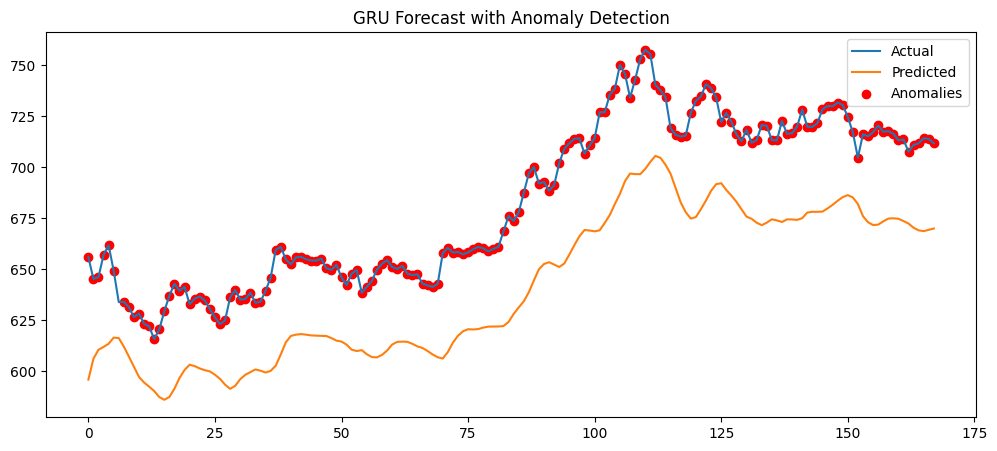

Detected 167 anomalies using residual thresholding.


In [16]:
# Anomaly Detection using Residuals
residuals = y_test_inv - y_pred_inv
threshold = 2 * np.std(residuals)
anomalies = np.where(np.abs(residuals) > threshold)[0]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.scatter(anomalies, y_test_inv[anomalies], color='red', label='Anomalies')
plt.title("GRU Forecast with Anomaly Detection")
plt.legend()
plt.show()

print(f"Detected {len(anomalies)} anomalies using residual thresholding.")


In [19]:
# ✅ Optional: Export results for downstream use
min_len = min(len(y_test_inv), len(y_pred_inv), len(residuals), len(anomalies))

forecast_df = pd.DataFrame({
    "Actual": y_test_inv[:min_len],
    "Predicted": y_pred_inv[:min_len],
    "Residual": residuals[:min_len],
    "Anomaly": anomalies[:min_len]
})

# Save full forecast with anomaly flags
forecast_df.to_csv('forecast_results.csv', index=False)

# Save just the anomaly flags (optional)
pd.DataFrame(anomalies[:min_len], columns=["Anomaly"]).to_csv('anomalies_detected.csv', index=False)